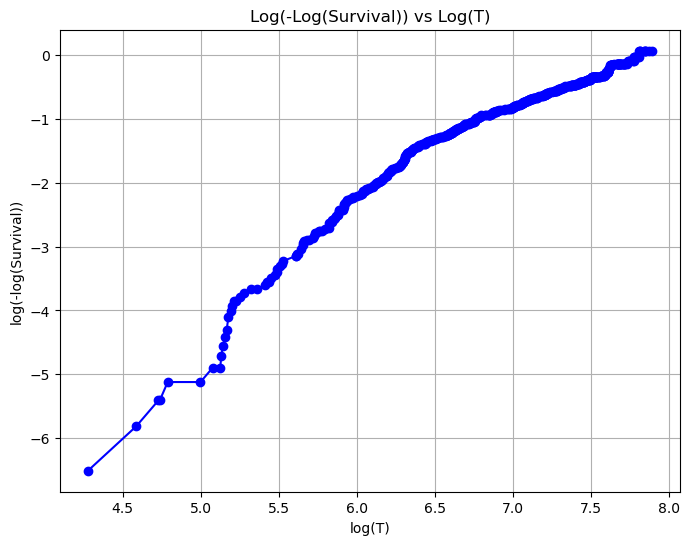

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('data/Recurrence free survival in breast cancer patients.csv')  # Replace with your file path

# Sort data by time
time_events = data[['time', 'status']].sort_values(by='time')
unique_times = time_events['time'].unique()

# Initialize counts
n_at_risk = len(time_events)
survival_prob = 1.0
survival_function = []

# Calculate the survival function
for t in unique_times:
    n_events = time_events[(time_events['time'] == t) & (time_events['status'] == 1)].shape[0]
    survival_prob *= (1 - n_events / n_at_risk)
    n_at_risk -= time_events[time_events['time'] == t].shape[0]
    survival_function.append((t, survival_prob))

# Convert survival function into DataFrame
survival_df = pd.DataFrame(survival_function, columns=['time', 'survival'])

# Filter out survival probabilities that are exactly 0 or 1
survival_df = survival_df[(survival_df['survival'] > 0) & (survival_df['survival'] < 1)]

# Calculate log(-log(survival)) and log(time)
survival_df['log_time'] = np.log(survival_df['time'])
survival_df['log_minus_log_survival'] = np.log(-np.log(survival_df['survival']))

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(survival_df['log_time'], survival_df['log_minus_log_survival'], marker='o', linestyle='-', color='b')
plt.xlabel('log(T)')
plt.ylabel('log(-log(Survival))')
plt.title('Log(-Log(Survival)) vs Log(T)')
plt.grid(True)
plt.show()


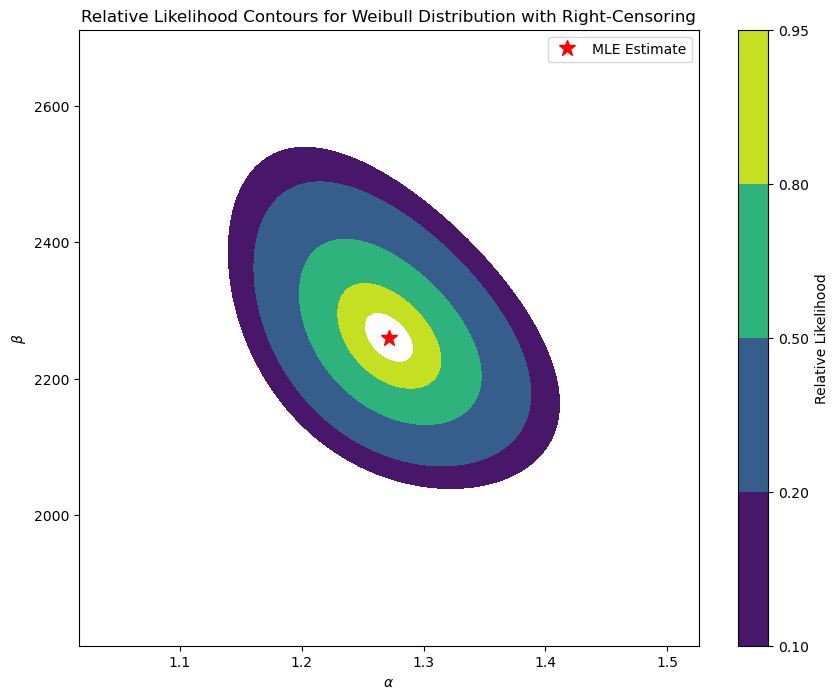

Estimated alpha: 1.2714677063686675
Estimated beta: 2260.0009543957785


In [3]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv('data/Recurrence free survival in breast cancer patients.csv')  # Replace with your file path

# Extract survival times and censoring indicators
survival_times = data['time'].values
censored = data['status'].values  # Assuming 1 for event and 0 for censoring

# Step 1: Initial estimates based on quantiles
# Estimate of beta
beta_initial = np.quantile(survival_times, 1 - np.exp(-1))

# Estimate of alpha
median_y = np.median(survival_times)
alpha_initial = np.log(np.log(2)) / np.log(median_y / beta_initial)

# Define the log-likelihood function for the Weibull distribution with right-censoring
def weibull_log_likelihood(params, times, censored):
    alpha, beta = params
    term1 = censored * (np.log(alpha) - alpha * np.log(beta) + (alpha - 1) * np.log(times))
    term2 = -((times / beta) ** alpha)
    log_likelihood = np.sum(term1 + term2)
    return -log_likelihood  # Return negative for minimization

# Step 2: Maximize the log-likelihood function to find the best alpha and beta
initial_params = [alpha_initial, beta_initial]
result = minimize(weibull_log_likelihood, initial_params, args=(survival_times, censored),
                  method='L-BFGS-B', bounds=[(0.01, None), (0.01, None)])

# Extract optimized alpha and beta values
alpha_mle, beta_mle = result.x

# Step 3: Generate a grid of alpha and beta values around the MLE estimates for contour plot
alpha_range = np.linspace(alpha_mle * 0.8, alpha_mle * 1.2, 100)
beta_range = np.linspace(beta_mle * 0.8, beta_mle * 1.2, 100)
alpha_grid, beta_grid = np.meshgrid(alpha_range, beta_range)

# Calculate relative likelihood values for each pair in the grid
log_likelihood_values = np.zeros_like(alpha_grid)

for i in range(alpha_grid.shape[0]):
    for j in range(alpha_grid.shape[1]):
        log_likelihood_values[i, j] = -weibull_log_likelihood(
            [alpha_grid[i, j], beta_grid[i, j]], survival_times, censored
        )

# Step 4: Convert log-likelihood to relative likelihood
max_log_likelihood = np.max(log_likelihood_values)
relative_likelihood_values = np.exp(log_likelihood_values - max_log_likelihood)

# Step 5: Plot the relative likelihood contour map
plt.figure(figsize=(10, 8))
contour = plt.contourf(alpha_grid, beta_grid, relative_likelihood_values, levels=[0.1, 0.2, 0.5, 0.8, 0.95], cmap='viridis')
plt.colorbar(contour, label='Relative Likelihood')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$')
plt.title('Relative Likelihood Contours for Weibull Distribution with Right-Censoring')
plt.plot(alpha_mle, beta_mle, 'r*', markersize=12, label='MLE Estimate')
plt.legend()
plt.show()

print(f"Estimated alpha: {alpha_mle}")
print(f"Estimated beta: {beta_mle}")


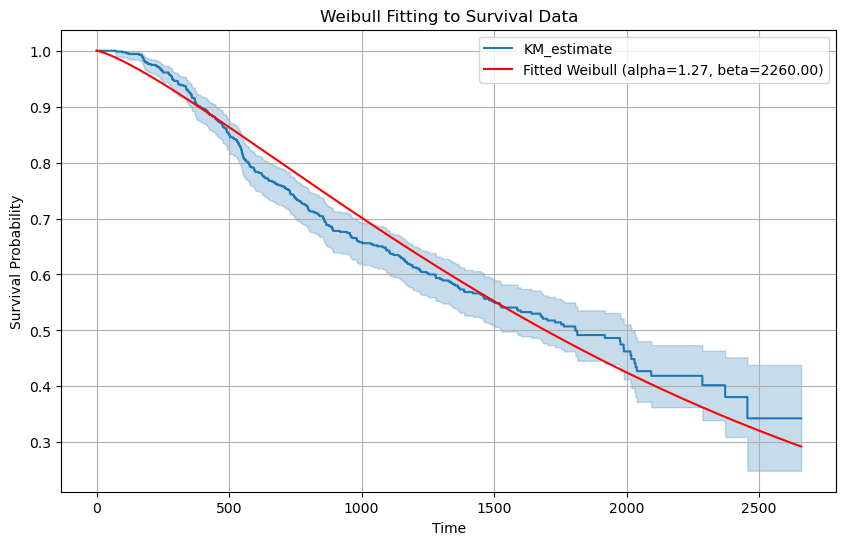

In [4]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
import numpy as np

# Fit the Kaplan-Meier estimator to the data
kmf = KaplanMeierFitter()
kmf.fit(data['time'], event_observed=data['status'])

# Fit the Weibull distribution to data with estimated alpha and beta
def weibull_cdf(t, alpha, beta):
    return 1 - np.exp(-(t / beta) ** alpha)

# Generate data points for plotting the fitted Weibull survival curve
time_range = np.linspace(0, max(survival_times), 500)
survival_curve = 1 - weibull_cdf(time_range, alpha_mle, beta_mle)

# Plot the Kaplan-Meier estimator and the fitted Weibull survival curve
plt.figure(figsize=(10, 6))
kmf.plot_survival_function()
plt.plot(time_range, survival_curve, 'r-', label=f'Fitted Weibull (alpha={alpha_mle:.2f}, beta={beta_mle:.2f})')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Weibull Fitting to Survival Data')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
from lifelines import WeibullFitter
wbf = WeibullFitter().fit(data['time'], data['status'], label='WeibullFitter')
wbf.print_summary()

<lifelines.WeibullFitter:"WeibullFitter", fitted with 686 total observations, 387 right-censored observations>
   number of observations = 686
number of events observed = 299
           log-likelihood = -2637.28
               hypothesis = lambda_ != 1, rho_ != 1

---
           coef  se(coef)  coef lower 95%  coef upper 95%
lambda_ 2259.85    114.89         2034.68         2485.03
rho_       1.27      0.06            1.15            1.40

         cmp to     z      p  -log2(p)
lambda_    1.00 19.66 <0.005    283.48
rho_       1.00  4.29 <0.005     15.78
---
AIC = 5278.55